In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

In [2]:
swb_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur_swb2.json'
    )

ponds_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells/output/17/gobindpur/gobindpur_COMBINED_GEOMETRY',
    'gobindpur_COMBINED_GEOMETRY.shp'
    )

mws_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur_mws.json'
    )

admin_boundary_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur_boundary.geojson'
    )


In [3]:
ponds_gdf = gpd.read_file(ponds_layer_path)

swb_gdf = gpd.read_file(swb_layer_path)

mws_gdf = gpd.read_file(mws_layer_path)

admin_boundary_gdf = gpd.read_file(admin_boundary_layer_path)

In [4]:
def split_multipolygon_into_individual_polygons(data_gdf):
    data_gdf = data_gdf.explode()
    return data_gdf

def clip_to_admin_boundary(data_gdf,boundary_gdf):
    data_gdf = data_gdf.sjoin(boundary_gdf[['geometry']],how = 'inner')
    data_gdf.drop(['index_right'],axis=1,inplace=True)
    return data_gdf

def change_crs(data_gdf,crs):
    data_gdf.to_crs(crs)
    return data_gdf

def generate_pond_id(data_gdf):
    data_gdf.drop(['FID'],axis=1,inplace=True,errors='ignore') #drop if the column exists
    data_gdf['pond_id'] = range(data_gdf.shape[0])
    return data_gdf

def dissolve_boundary(data_gdf):
    data_gdf = data_gdf.dissolve()
    return data_gdf

In [5]:
if (ponds_gdf.shape[0] == 1):
    ponds_gdf = split_multipolygon_into_individual_polygons(ponds_gdf)
    ponds_gdf = generate_pond_id(ponds_gdf)

In [6]:
# ponds_gdf.head()

In [7]:
if (admin_boundary_gdf.shape[0] > 1):
    admin_boundary_gdf = dissolve_boundary(admin_boundary_gdf)

In [8]:
# admin_boundary_gdf

In [9]:
ponds_gdf = clip_to_admin_boundary(
    data_gdf=ponds_gdf,
    boundary_gdf=admin_boundary_gdf
)

In [10]:
# ponds_gdf.shape

In [11]:
swb_gdf = clip_to_admin_boundary(
    data_gdf=swb_gdf,
    boundary_gdf=admin_boundary_gdf
)

In [12]:
swb_gdf.shape

(6600, 36)

In [13]:
# swb_gdf = change_crs(
#     data_gdf=swb_gdf,
#     crs='crs:7755'
# )

# ponds_gdf = change_crs(
#     data_gdf=ponds_gdf,
#     crs='crs:7755'
# )

### Create merged dataframe

1. Add standalone swb

In [14]:
intersecting_UIDs = swb_gdf.sjoin(ponds_gdf)['UID'].tolist()

In [15]:
standalone_swb_gdf = swb_gdf[~swb_gdf['UID'].isin(intersecting_UIDs)]

In [16]:
standalone_swb_gdf.shape

(5561, 36)

In [17]:
merged_gdf = standalone_swb_gdf

2. Add standalone ponds

In [18]:
intersecting_pond_ids = ponds_gdf.sjoin(swb_gdf)['pond_id'].tolist()

In [19]:
standalone_ponds_gdf = ponds_gdf[~ponds_gdf['pond_id'].isin(intersecting_pond_ids)]

In [20]:
merged_gdf = pd.concat([merged_gdf,
                        standalone_ponds_gdf])

In [21]:
merged_gdf.shape

(6373, 37)

#### Intersection scenarios

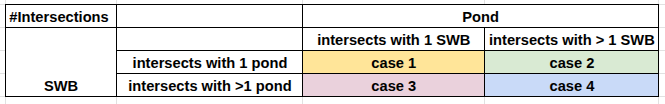

In [22]:
intersections_gdf = swb_gdf.sjoin(ponds_gdf)

In [23]:
ponds_gdf

,geometry,pond_id
0,"POLYGON ((86.24542 22.98588, 86.24542 22.9859,...",526
0,"POLYGON ((86.24094 22.97678, 86.24094 22.97679...",566
0,"POLYGON ((86.22695 22.97532, 86.22695 22.97532...",679
0,"POLYGON ((86.22416 22.97425, 86.22418 22.97426...",707
0,"POLYGON ((86.21476 22.99128, 86.21476 22.99129...",792
...,...,...
0,"POLYGON ((85.64871 22.87705, 85.64871 22.87706...",4288
0,"POLYGON ((85.6491 22.87819, 85.64908 22.87822,...",4289
0,"POLYGON ((85.64802 22.90025, 85.64802 22.90027...",4292
0,"POLYGON ((85.64667 22.9014, 85.64667 22.90141,...",4293


In [24]:
intersections_gdf.shape

(1067, 38)

In [25]:
ponds_gdf

,geometry,pond_id
0,"POLYGON ((86.24542 22.98588, 86.24542 22.9859,...",526
0,"POLYGON ((86.24094 22.97678, 86.24094 22.97679...",566
0,"POLYGON ((86.22695 22.97532, 86.22695 22.97532...",679
0,"POLYGON ((86.22416 22.97425, 86.22418 22.97426...",707
0,"POLYGON ((86.21476 22.99128, 86.21476 22.99129...",792
...,...,...
0,"POLYGON ((85.64871 22.87705, 85.64871 22.87706...",4288
0,"POLYGON ((85.6491 22.87819, 85.64908 22.87822,...",4289
0,"POLYGON ((85.64802 22.90025, 85.64802 22.90027...",4292
0,"POLYGON ((85.64667 22.9014, 85.64667 22.90141,...",4293


In [28]:
swb_intersections_df = intersections_gdf.groupby(['UID'])['pond_id'].unique().reset_index()

In [30]:
pond_intersections_df = intersections_gdf.groupby(['pond_id'])['UID'].unique().reset_index()